# loading packages and data

In [49]:
#from google.colab import drive
#drive.mount('/content/drive')



In [50]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
from itertools import cycle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import multiprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, BatchNormalization , MaxPooling2D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
devider = "-------------------------------------------------------------------------------------------------------------------------------------"
print ('modules loaded')

modules loaded


In [ ]:
# Replace these paths with the actual paths to your dataset folders
data_dir = 'INSERT-OWN-DRIVE-OR-DIR-WHERE-IMG-PRESENT'


filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("location/yourownname.npy",image_matrix) # Saving as a npy file so that we can just load it later
np.save("location/yourownname.npy",tr_labels)


In [52]:
# Cheek if tensorflow has been initiated in GPU mode
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))



2.15.0
Num GPUs Available:  1


In [53]:
# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()

print(f"Number of CPU cores available: {num_cores}")


Number of CPU cores available: 16


## Loading the data

In [54]:
file_dir = "/mnt/c/Users/user/Desktop/Deep learning assignmnet/test/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)



['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


## Removing duplicates 

After running multiple models I noticed mismatches in the performance metrics of the models 
I found out using the code from the EXTRA section that the data inherits duplicates that automatically cause than leakage in the split
I referred to the assignment description to decide if these duplicates which are at a total of 1280 observations should be dropped. 
There was no guidelines to this, thus asserting model performance I decided to drop these duplicates using the snippet below.

In [55]:

import hashlib

def hash_image(image_array):
    """Compute a hash of an image array."""
    return hashlib.sha256(image_array).hexdigest()

def remove_duplicates(data, labels):
    unique_hashes = set()
    unique_data = []
    unique_labels = []
    
    for idx, image in enumerate(data):
        image_hash = hash_image(image)
        if image_hash not in unique_hashes:
            unique_hashes.add(image_hash)
            unique_data.append(image)
            unique_labels.append(labels[idx])
    
    return np.array(unique_data), np.array(unique_labels)

# Call the function to remove duplicates

print(f"Original dataset size: {data.shape[0]}")

data, labels = remove_duplicates(data, labels)
print(f"Dataset size after removing duplicates: {data.shape[0]}")


Original dataset size: 25000
Dataset size after removing duplicates: 23720


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [14]:


num_classes=len(np.unique(labels))
print(f'num of classes = {num_classes}')
# 5 Different cancers

# Reshape labels to (-1, 1) because it's a single feature
labels1 = labels.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # Use sparse=False to get a dense array

# Fit and transform the labels
labels1 = encoder.fit_transform(labels1)

# one_hot_labels is now a one-hot encoded representation of your labels
print(labels1)

# To get the feature names (class names in this case) after encoding
feature_names = encoder.get_feature_names_out(input_features=['labels'])
print(feature_names)

# The one hot encoded labels are present in the variable labels1
# This usage of naming is done to adhere to later checks...



num of classes = 5
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
['labels_Colon Benign Tissue' 'labels_Colon adenocarcinoma'
 'labels_Lung Benign Tissue' 'labels_Lung Squamous Cell Carcinoma'
 'labels_Lung adenocarcinoma']


## Visualizing Sample Images

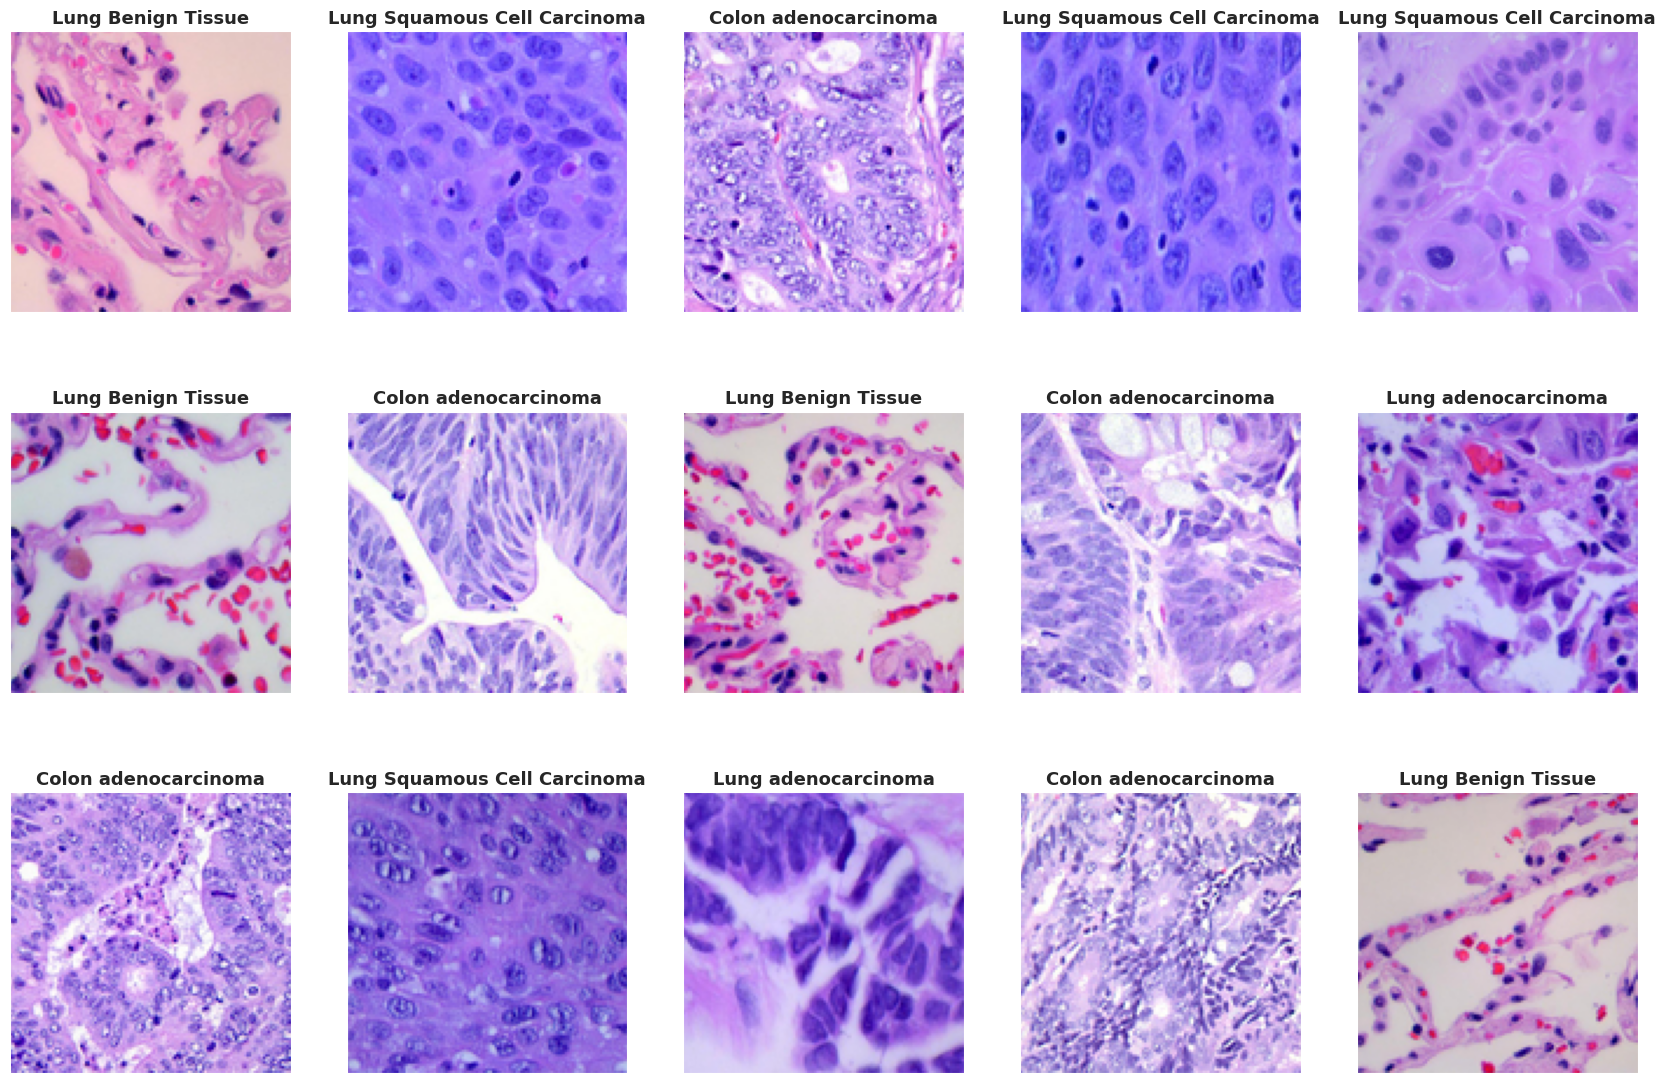

In [15]:

# data is the images array and `labels` is an array of labels
def imgshower(data, labels):
    # Generate 15 unique random indices
    random_indices = np.random.choice(data.shape[0], 15, replace=False)

    # Set up the matplotlib figure and axes,
    # assuming a 3x5 grid for 15 images
    fig, axs = plt.subplots(3, 5, figsize=(21, 14))

    for ax, idx in zip(axs.flat, random_indices):
        # Display image
        ax.imshow(data[idx])
        # Display label
        label = labels[idx]  # Assuming labels are not one-hot encoded
        ax.set_title(label, fontdict={
            'fontsize': 13,   # You can adjust the size here
            'weight': 'bold',  # You can make the text bold
        })
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])


    plt.show()

# Example usage
imgshower(data, labels)


## Visualizing Class Distribution

Total number of observations per unique class: [4772. 4753. 4744. 4724. 4727.]


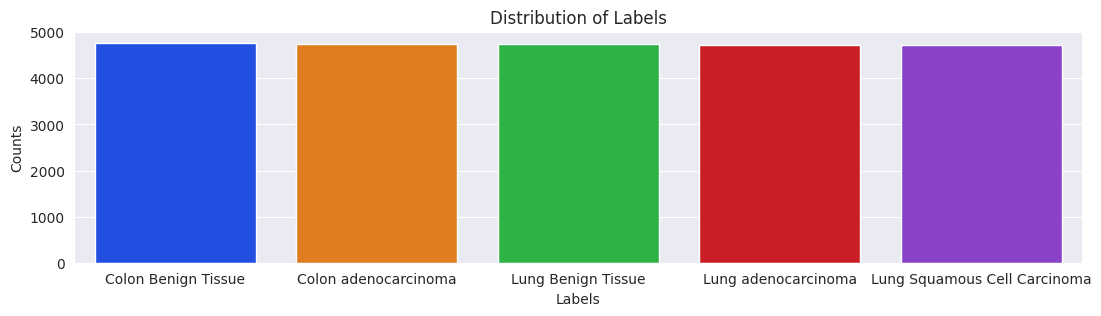

In [16]:
class_counts = np.sum(labels1 , axis= 0)
print(f"Total number of observations per unique class: {class_counts}")

# convert to pd dataframe for easier navigation
labels_series = pd.Series(labels)
# create the plot
plt.figure(figsize=(13,3))
sns.countplot(x = labels_series, order = labels_series.value_counts().index, palette='bright')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

# labels are uniformly distributed also confirmed from class_counts which is created
# from variable labels1 and not labels

### Splitting the data


To split the data a four step procedure is followed:
1. Preliminary check to ensure labels order was preserved after encoding

2. Split data into training and temporary set(temporary set will be further split into validation and test sets)

3. We use the original labels array for
   stratification to ensure each split has proportional representation of each class
   unify data types for both labels1 and data
4. Function to verify if the split preserved the order of samples correctly


In [17]:

# Starting step 1

labels_reversed = encoder.inverse_transform(labels1)

# Since labels_reversed will be in the shape (-1, 1), we must flatten it
# for a direct comparison
labels_reversed = labels_reversed.flatten()

# Check if the original labels and the reversed labels match
matching_labels = np.array_equal(labels, labels_reversed)
print(f"Do the original and reversed labels match? {matching_labels}")

# Starting step 2
indices = np.arange(data.shape[0])

x_train, x_temp, y_train, y_temp, indices_train, indices_temp = train_test_split(
    data, labels1, indices, test_size=0.4, random_state=42, stratify=labels1)

# starting Step 3
x_val, x_test, y_val, y_test, indices_val, indices_test = train_test_split(
    x_temp, y_temp, indices_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Starting step 4 -OPTIONAL REMOVED AFTER THE FIRST RUN SINCE CHEECK HOLDS AND IT IMPACTS RUNTIME !!!<------------------------

# def verify_split(indices, x, y, original_data, original_labels):
#     for i, index in enumerate(indices):
#         if not np.array_equal(x[i], original_data[index]) or not np.array_equal(y[i], original_labels[index]):
#             return False
#     return True

#train_verified = verify_split(indices_train, x_train, y_train, data, labels1)
#val_verified = verify_split(indices_val, x_val, y_val, data, labels1)
#test_verified = verify_split(indices_test, x_test, y_test, data, labels1)

# Showcasing results

#print("Index check is a pass:",
     # f"Train data: {train_verified}",
     # f"Validation data: {val_verified}",
     # f"Test data: {test_verified}")


print("Data spliting procedure is finalized showcasing results: ")
print(f"Training set shape: {x_train.shape}, {y_train.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")
print("Split and check complete")





Do the original and reversed labels match? True
Data spliting procedure is finalized showcasing results: 
Training set shape: (14232, 120, 120, 3), (14232, 5)
Validation set shape: (4744, 120, 120, 3), (4744, 5)
Test set shape: (4744, 120, 120, 3), (4744, 5)
Split and check complete


# Evaluation Functions

## Loss - Acc graphs:

In [18]:
def plot_training_history(history, figsize=(12, 15)):
    # Extracting the history records
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Finding the best/worst epochs
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Preparing epoch labels
    Epochs = [i+1 for i in range(len(train_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plotting
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 20}) 
    plt.style.use('fivethirtyeight')

    # Loss plot
    plt.subplot(2, 1, 1)
    plt.plot(Epochs, train_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 1, 2)
    plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Classification Report and Confusion matrix:

In [19]:
# Function to calculate and print performance metrics
def print_performance_metrics(y_true, y_pred_labels):
    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels, average='macro')
    recall = recall_score(y_true, y_pred_labels, average='macro')
    f1 = f1_score(y_true, y_pred_labels, average='macro')

    print(f'Accuracy: {accuracy:.7f}')
    print(f'Precision: {precision:.7f}')
    print(f'Recall: {recall:.7f}')
    print(f'F1-Score: {f1:.7f}')


# Function to map class indices back to class names
def indices_to_names(indices, class_names):
    return np.array([class_names[i] for i in indices])


# # Function to plot confusion matrix with class names and adjustable text size
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', figsize=(14, 12), fontsize=17 , xtick_rotation = 30):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred, labels=classes)
  # Normalize confusion matrix
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=figsize ,dpi = 100)
  sns.heatmap(cm_normalized, annot=True, cmap="Oranges", xticklabels=classes, yticklabels=classes, annot_kws={"size": fontsize})
  plt.title(title, size=fontsize + 2)
  plt.ylabel('True label', size=fontsize)
  plt.xlabel('Predicted label', size=fontsize)
  plt.xticks(fontsize=fontsize - 2, rotation=xtick_rotation)
  plt.yticks(fontsize=fontsize - 2 , rotation = 0)
  plt.tight_layout()
  plt.show()


## ROC curves


In [20]:
def plot_multiclass_roc_auc(y_true, y_pred, class_names ,title):
    # Binarize the output
    classes = np.arange(len(class_names))  # Create an array of class indices
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    

    # Plot ROC curve for each class
    plt.figure(figsize=(14, 12))
    lw = 2

    plt.rcParams.update({'font.size': 18}) 
    title_fontsize = 17  # Font size for title
    label_fontsize = 12  # Font size for x and y labels
    legend_fontsize = 18  # Font size for legend
    
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (AUC = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


# Baseline Model

In [21]:
# Defining vars 
img_size = (x_train.shape[1], x_train.shape[2])
channels = x_train.shape[3]
img_shape = (img_size[0], img_size[1], channels)
class_count = np.sum(np.any(y_train, axis=0))

In [25]:

# Building the model ---
model = Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dense(32,activation = "relu"))
model.add(layers.Dense(class_count, activation = "softmax"))

model.summary()
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

2024-03-09 17:48:57.833616: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614822400 exceeds 10% of free system memory.
2024-03-09 17:48:58.711672: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614822400 exceeds 10% of free system memory.


Epoch 1/10
445/445 [==============================] - 16s 33ms/step - loss: 2.7348 - accuracy: 0.4292 - val_loss: 1.1430 - val_accuracy: 0.4418
Epoch 2/10
445/445 [==============================] - 13s 29ms/step - loss: 1.0933 - accuracy: 0.4993 - val_loss: 0.9344 - val_accuracy: 0.5373
Epoch 3/10
445/445 [==============================] - 13s 29ms/step - loss: 1.0681 - accuracy: 0.4859 - val_loss: 1.0291 - val_accuracy: 0.5108
Epoch 4/10
445/445 [==============================] - 13s 29ms/step - loss: 0.9973 - accuracy: 0.5216 - val_loss: 0.9271 - val_accuracy: 0.5679
Epoch 5/10
445/445 [==============================] - 13s 29ms/step - loss: 0.9472 - accuracy: 0.5511 - val_loss: 0.9324 - val_accuracy: 0.5535
Epoch 6/10
445/445 [==============================] - 13s 29ms/step - loss: 0.8788 - accuracy: 0.5864 - val_loss: 0.8799 - val_accuracy: 0.5915
Epoch 7/10
445/445 [==============================] - 13s 29ms/step - loss: 0.8834 - accuracy: 0.5986 - val_loss: 1.0845 - val_accuracy:

In [ ]:
model.save('/mnt/c/Users/user/Desktop/Deep learning assignmnet/baseline_final.h5')


In [34]:
# Use just in case across multiple runs there is a memory shortage run this cell !! 
import gc
gc.collect()  # Force garbage collection


0

# Enhanced Model

In [79]:
# Define the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape))
model.add(Conv2D(64, kernel_size=(5,5), padding="same", activation="relu"))  # Changed kernel size
model.add(MaxPooling2D((2, 2)))

# Additional Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Additional Convolutional Layer with L2 Regularization
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))  # Added Dropout
model.add(Dense(64, activation="relu"))
model.add(Dense(class_count, activation="softmax"))

# Compile the model using Adamax optimizer with a slower learning rate
model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()

#Fitting model with early stop


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# Fit the model with EarlyStopping
history = model.fit(
    x_train, y_train,
    epochs=30,  
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]  # Include the EarlyStopping callback here
)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                 

2024-03-09 17:18:58.436779: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614822400 exceeds 10% of free system memory.


Epoch 1/30


2024-03-09 17:19:07.618165: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:07.839741: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:07.963135: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:08.151342: W external/local_tsl/tsl/framework/bfc_

444/445 [============================>.] - ETA: 0s - loss: 1.1444 - accuracy: 0.7088

2024-03-09 17:19:54.402936: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:54.581509: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:54.702067: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 17:19:54.876571: W external/local_tsl/tsl/framework/bfc_

445/445 [==============================] - 63s 112ms/step - loss: 1.1439 - accuracy: 0.7088 - val_loss: 0.7044 - val_accuracy: 0.8792
Epoch 2/30
445/445 [==============================] - 42s 93ms/step - loss: 0.6296 - accuracy: 0.8869 - val_loss: 0.5924 - val_accuracy: 0.8997
Epoch 3/30
445/445 [==============================] - 42s 93ms/step - loss: 0.5023 - accuracy: 0.9257 - val_loss: 0.4894 - val_accuracy: 0.9271
Epoch 4/30
445/445 [==============================] - 42s 93ms/step - loss: 0.4333 - accuracy: 0.9414 - val_loss: 0.4076 - val_accuracy: 0.9454
Epoch 5/30
445/445 [==============================] - 42s 93ms/step - loss: 0.3820 - accuracy: 0.9547 - val_loss: 0.3614 - val_accuracy: 0.9602
Epoch 6/30
445/445 [==============================] - 42s 94ms/step - loss: 0.3462 - accuracy: 0.9613 - val_loss: 0.3309 - val_accuracy: 0.9642
Epoch 7/30
445/445 [==============================] - 42s 94ms/step - loss: 0.3125 - accuracy: 0.9682 - val_loss: 0.3174 - val_accuracy: 0.9618
Ep

In [ ]:
model.save('/mnt/c/Users/user/Desktop/Deep learning assignmnet/final_model.h5')


In [ ]:
# Use just in case across multiple runs there is a memory shortage run this cell !! 
import gc
gc.collect()  # Force garbage collection

# Transfer Learning Model


In [42]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load the ResNet50 model pre-trained on ImageNet data, excluding the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers of the base_model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')  # Assuming class_count is the number of classes in your dataset
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with EarlyStopping
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/30
445/445 [==============================] - 21s 39ms/step - loss: 0.2086 - accuracy: 0.9225 - val_loss: 0.1208 - val_accuracy: 0.9591
Epoch 2/30
445/445 [==============================] - 16s 37ms/step - loss: 0.1056 - accuracy: 0.9615 - val_loss: 0.0848 - val_accuracy: 0.9739
Epoch 3/30
445/445 [==============================] - 16s 37ms/step - loss: 0.0815 - accuracy: 0.9697 - val_loss: 0.0766 - val_accuracy: 0.9743
Epoch 4/30
445/445 [==============================] - 16s 37ms/step - loss: 0.0649 - accuracy: 0.9763 - val_loss: 0.0638 - val_accuracy: 0.9793
Epoch 5/30
445/445 [==============================] - 16s 37ms/step - loss: 0.0551 - accuracy: 0.9809 - val_loss: 0.0641 - val_accuracy: 0.9764
Epoch 6/30
445/445 [==============================] - 16s 37ms/step - loss: 0.0467 - accuracy: 0.9827 - val_loss: 0.0533 - val_accuracy: 0.9836
Epoch 7/30
445/445 [==============================] - 16s 37ms/step - loss: 0.0399 - accuracy: 0.9857 - val_loss: 0.0497 - val_accuracy:

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                      

# Evaluation of the base model:

The code below evaluates based line model


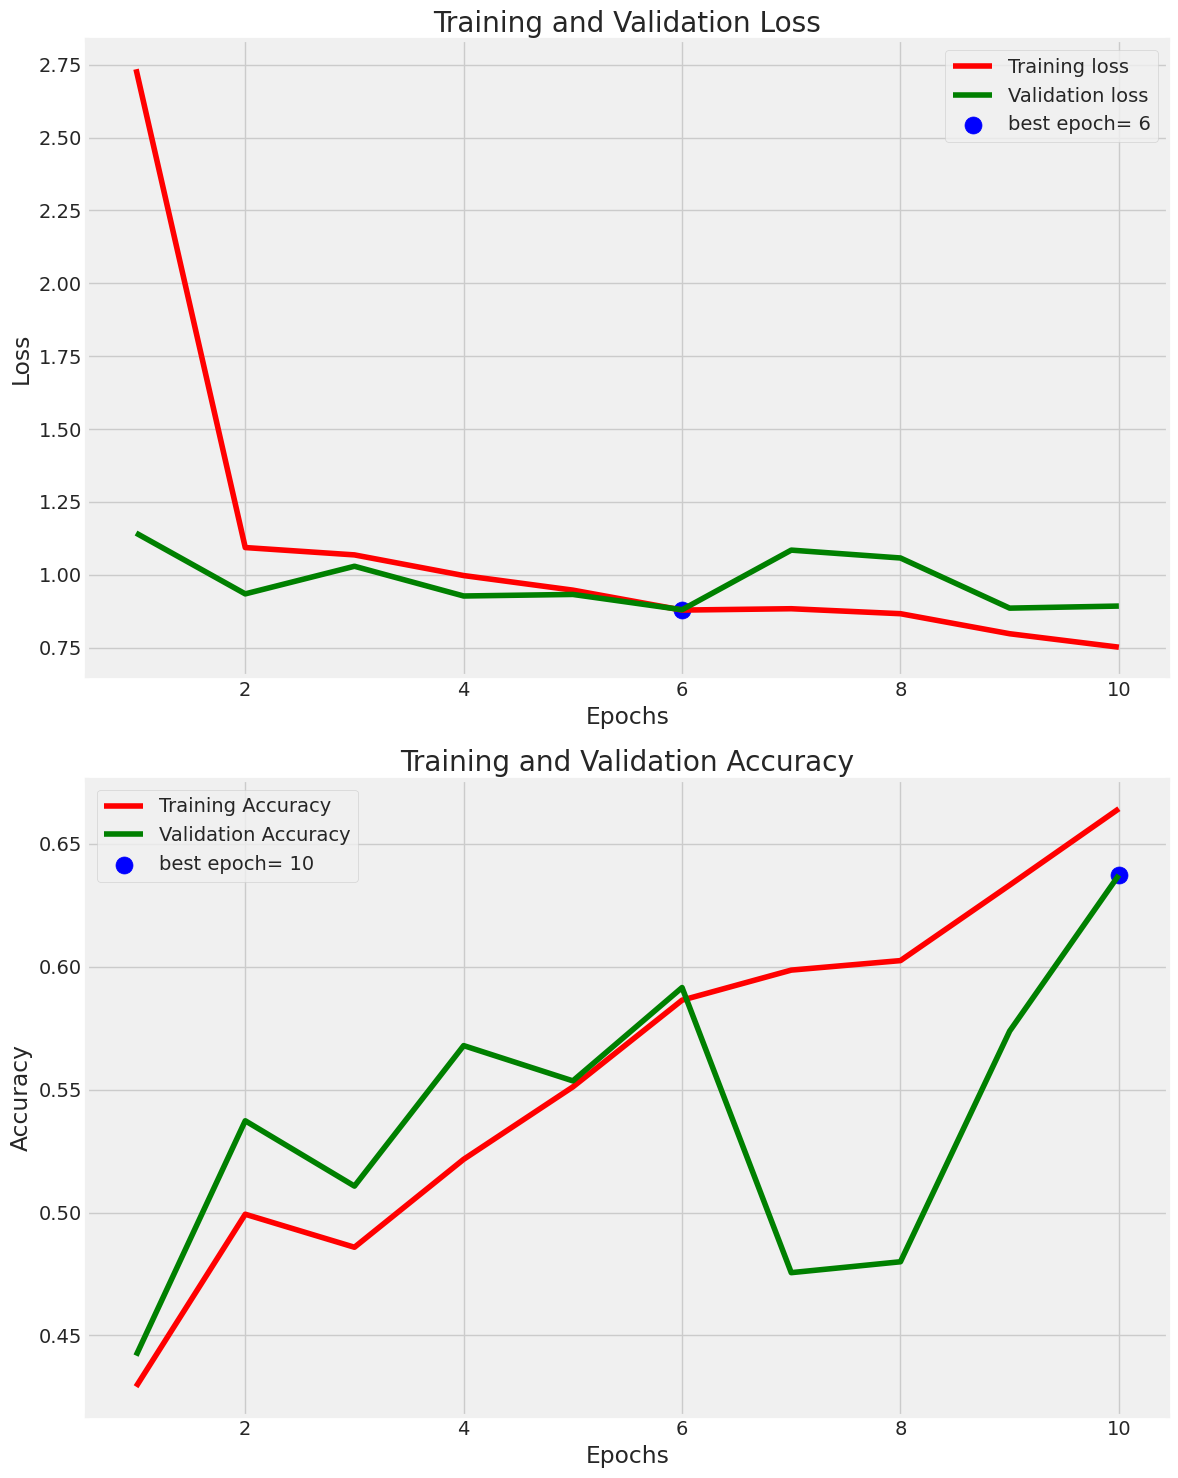

In [27]:
# Plot Loss-Acc Graphs:

plot_training_history(history)

149/149 [==============================] - 1s 9ms/step


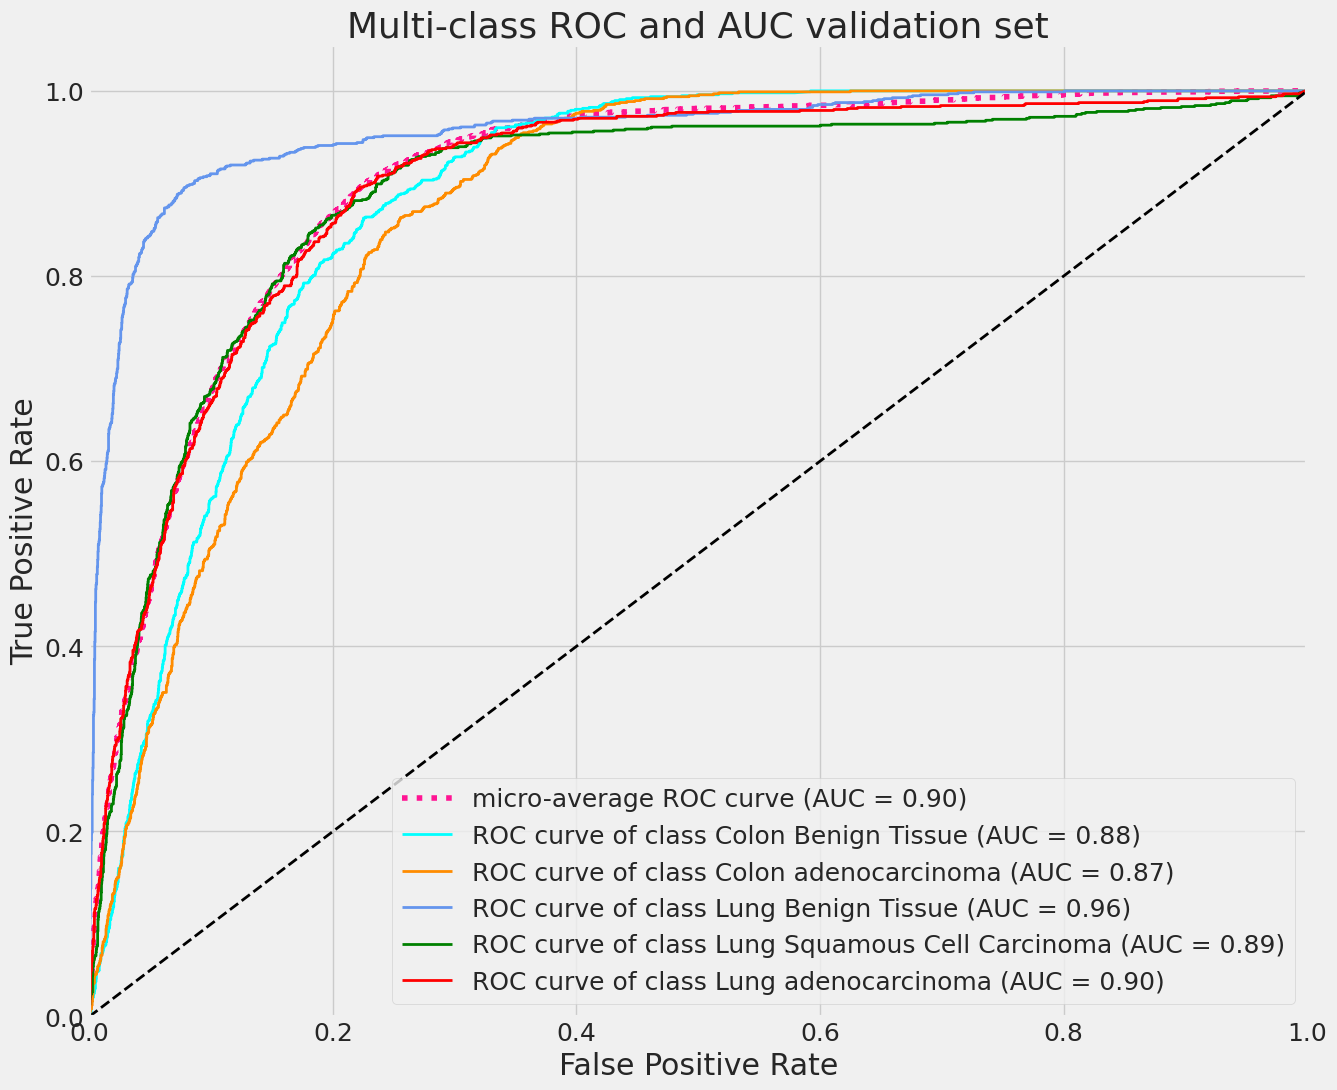

In [28]:
# Plotting ROC curvers :
unique_class_names = np.unique(labels)
## Get model predictions
y_val_pred_proba = model.predict(x_val)
y_test_pred_proba = model.predict(x_test)

## Convert predictions and true labels to class labels
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

## Plot ROC and calculate AUC for validation set
plot_multiclass_roc_auc(y_val_true, y_val_pred_proba, unique_class_names , title = 'Multi-class ROC and AUC validation set')




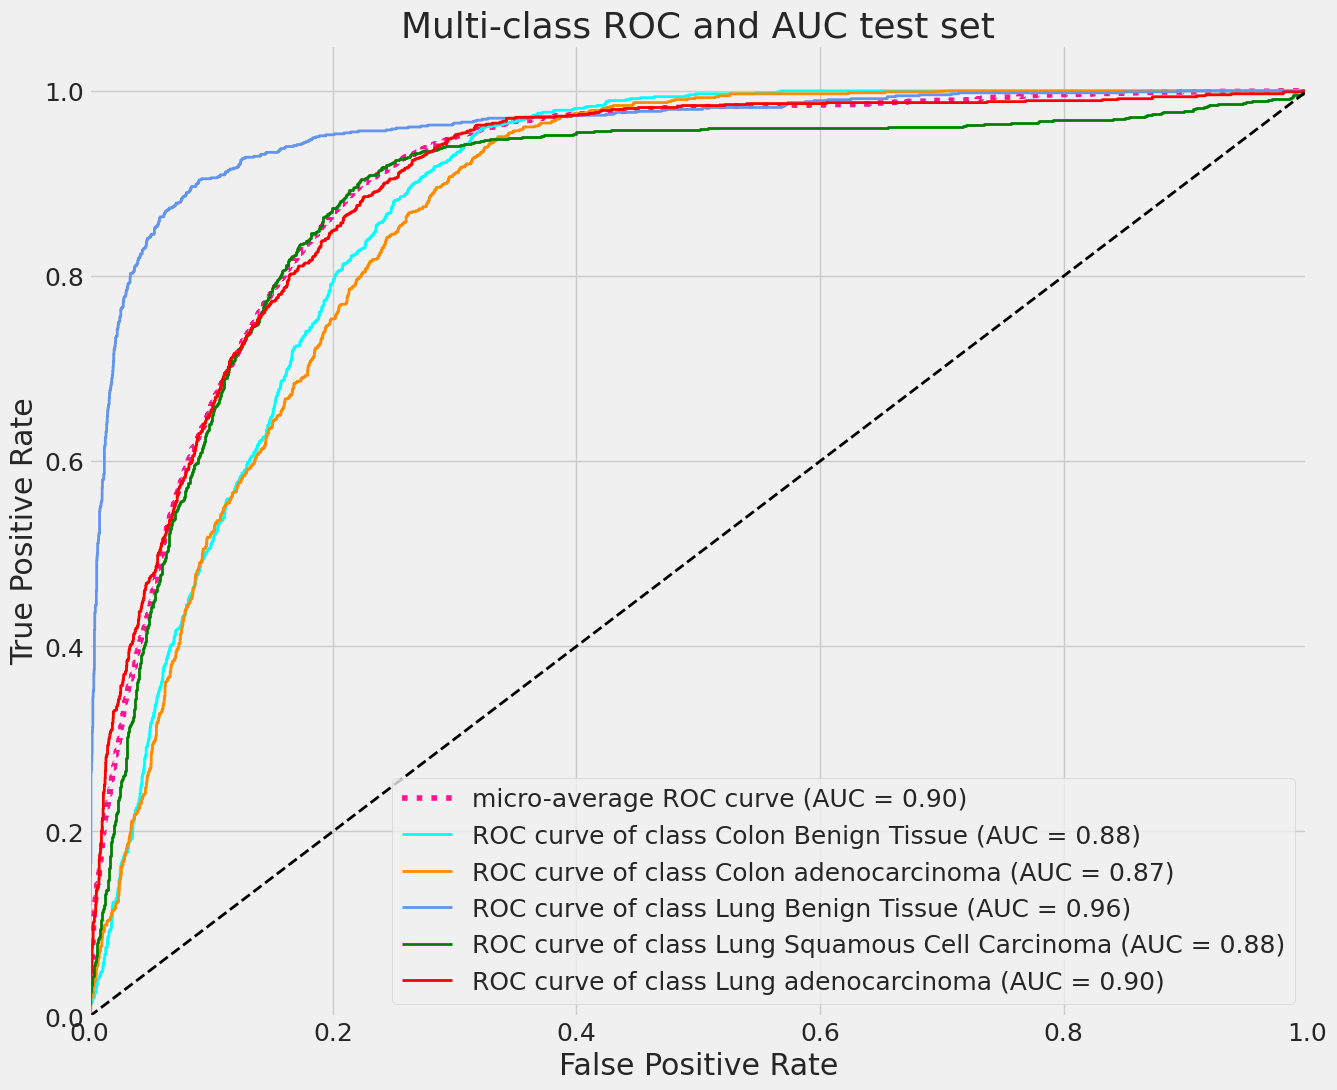

In [29]:
## Plot ROC and calculate AUC for test set
plot_multiclass_roc_auc(y_test_true, y_test_pred_proba,  unique_class_names,  title = 'Multi-class ROC and AUC test set')

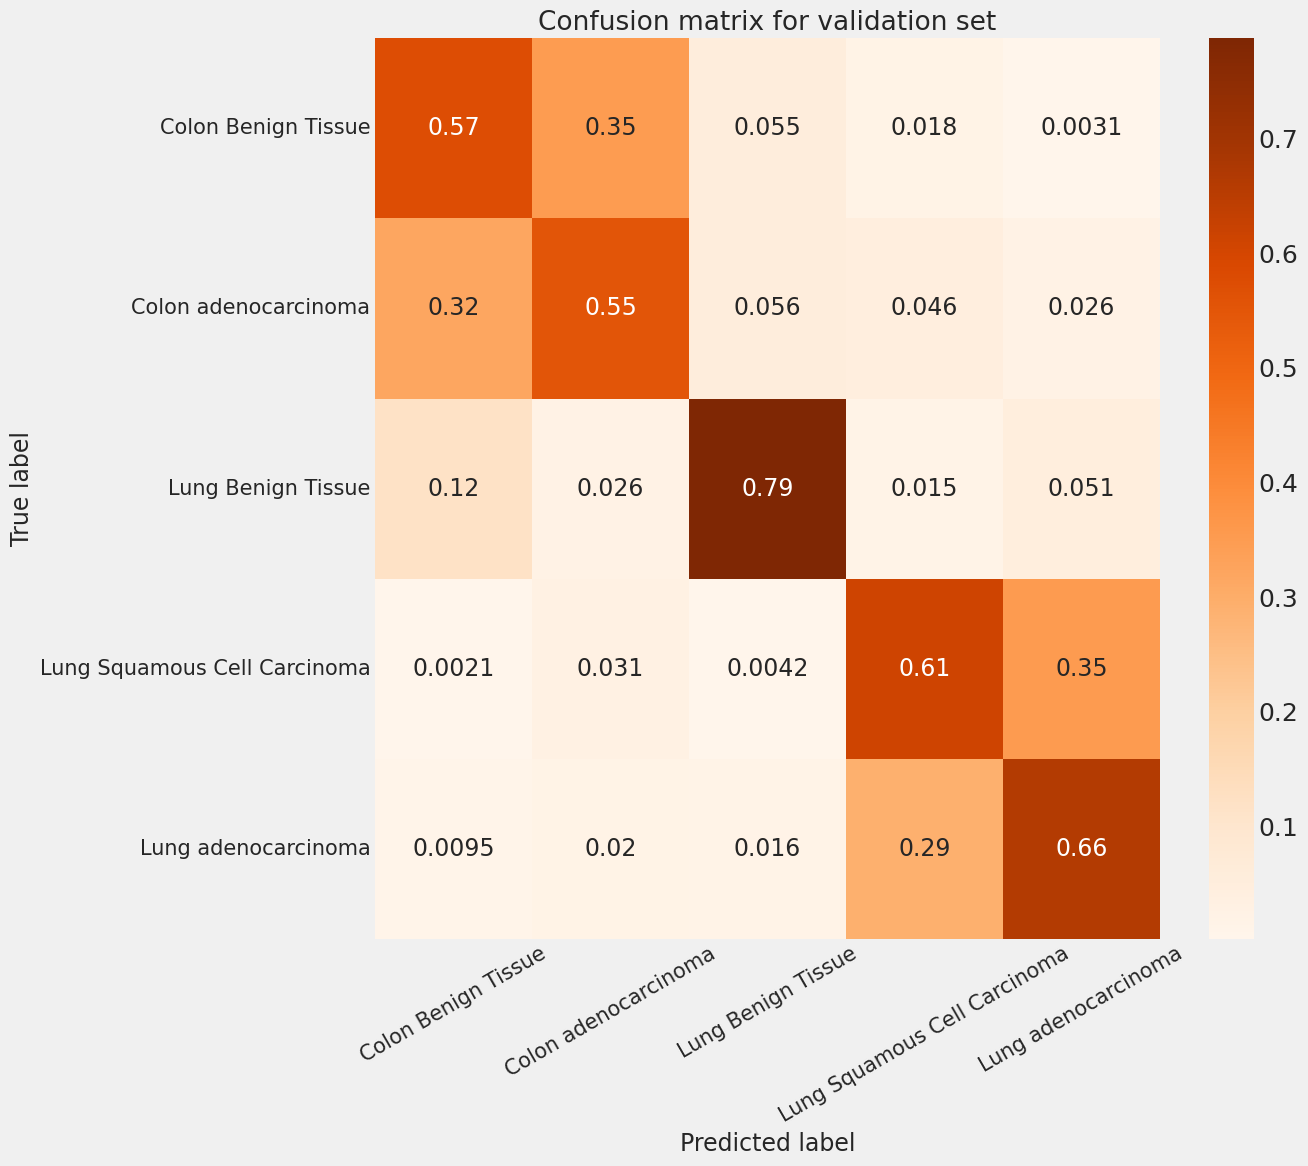

In [30]:
# Conf Matrix and classification Report:
## Extract unique class names from the `labels` array
unique_class_names = np.unique(labels)

## Map the class indices back to class names
y_val_true_names = indices_to_names(y_val_true, unique_class_names)
y_test_true_names = indices_to_names(y_test_true, unique_class_names)
y_val_pred_names = indices_to_names(y_val_pred, unique_class_names)
y_test_pred_names = indices_to_names(y_test_pred, unique_class_names)


## Plot confusion matrix for validation set with adjusted text size
plot_confusion_matrix(y_val_true_names, y_val_pred_names, unique_class_names, title='Confusion matrix for validation set')



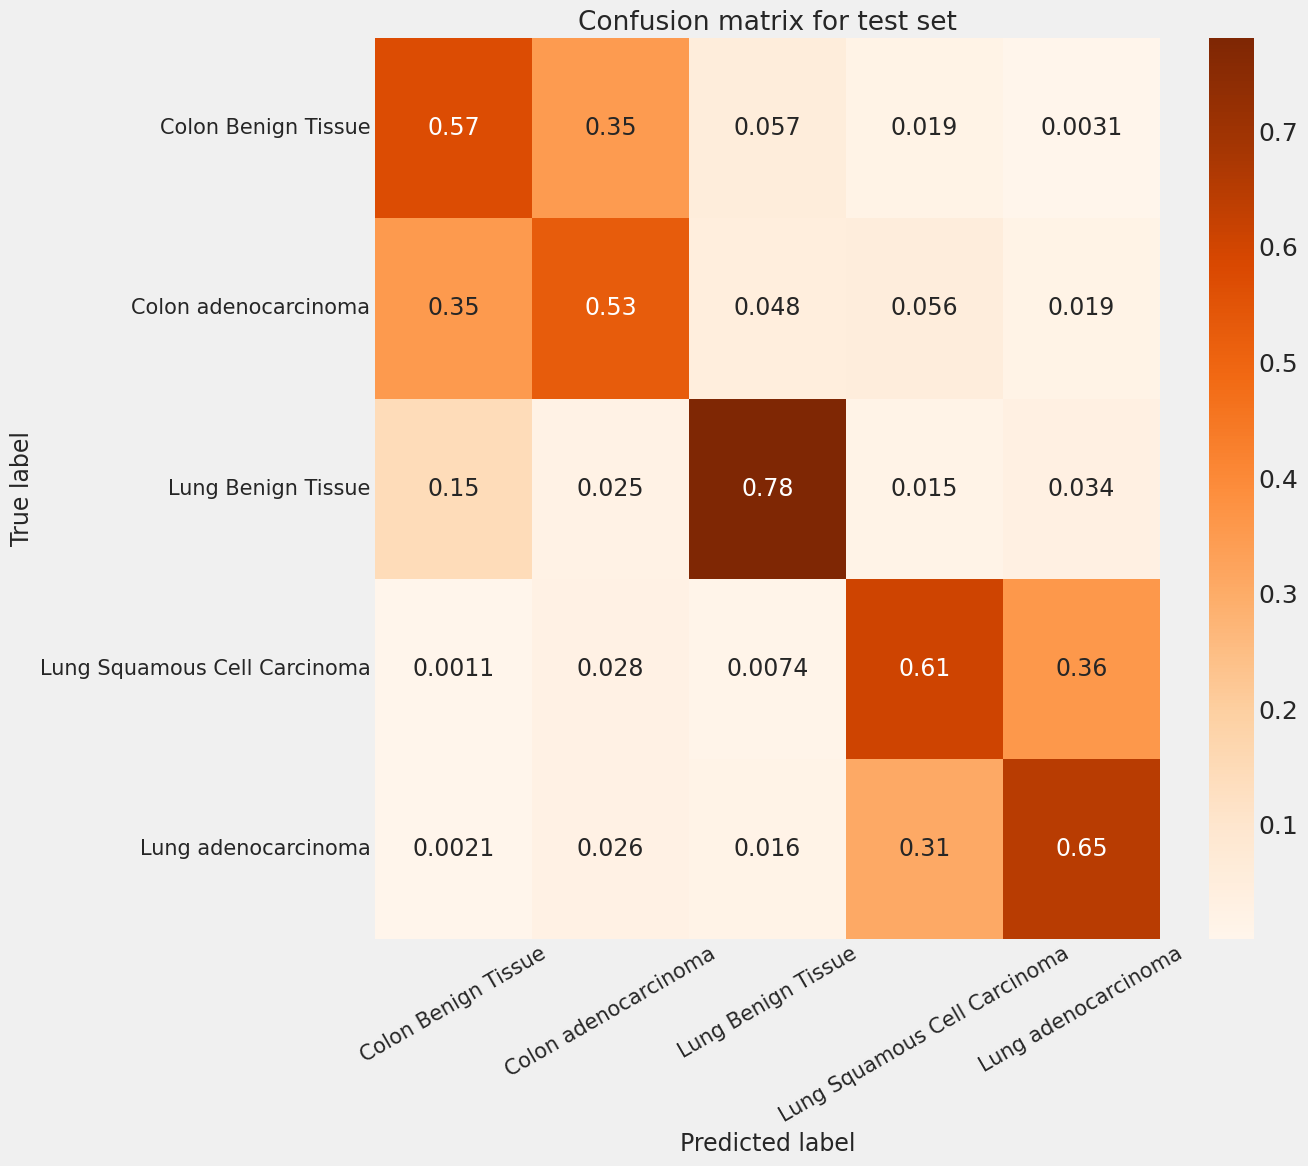

In [31]:
## Plot confusion matrix for test set with adjusted text size
plot_confusion_matrix(y_test_true_names, y_test_pred_names, classes=unique_class_names, title='Confusion matrix for test set')

In [32]:
## Calculate and print performance metrics for test set
print("\nTest Set Performance:")
print_performance_metrics(y_test_true, y_test_pred)

print(devider) 

## Calculate and print performance metrics for validation set
print("Validation Set Performance:")
print_performance_metrics(y_val_true, y_val_pred)


Test Set Performance:
Accuracy: 0.6262648
Precision: 0.6314297
Recall: 0.6263843
F1-Score: 0.6282395
-------------------------------------------------------------------------------------------------------------------------------------
Validation Set Performance:
Accuracy: 0.6372260
Precision: 0.6415730
Recall: 0.6373268
F1-Score: 0.6388470


# Evaluation of enhanced model

The code below evaluates the enhanced model

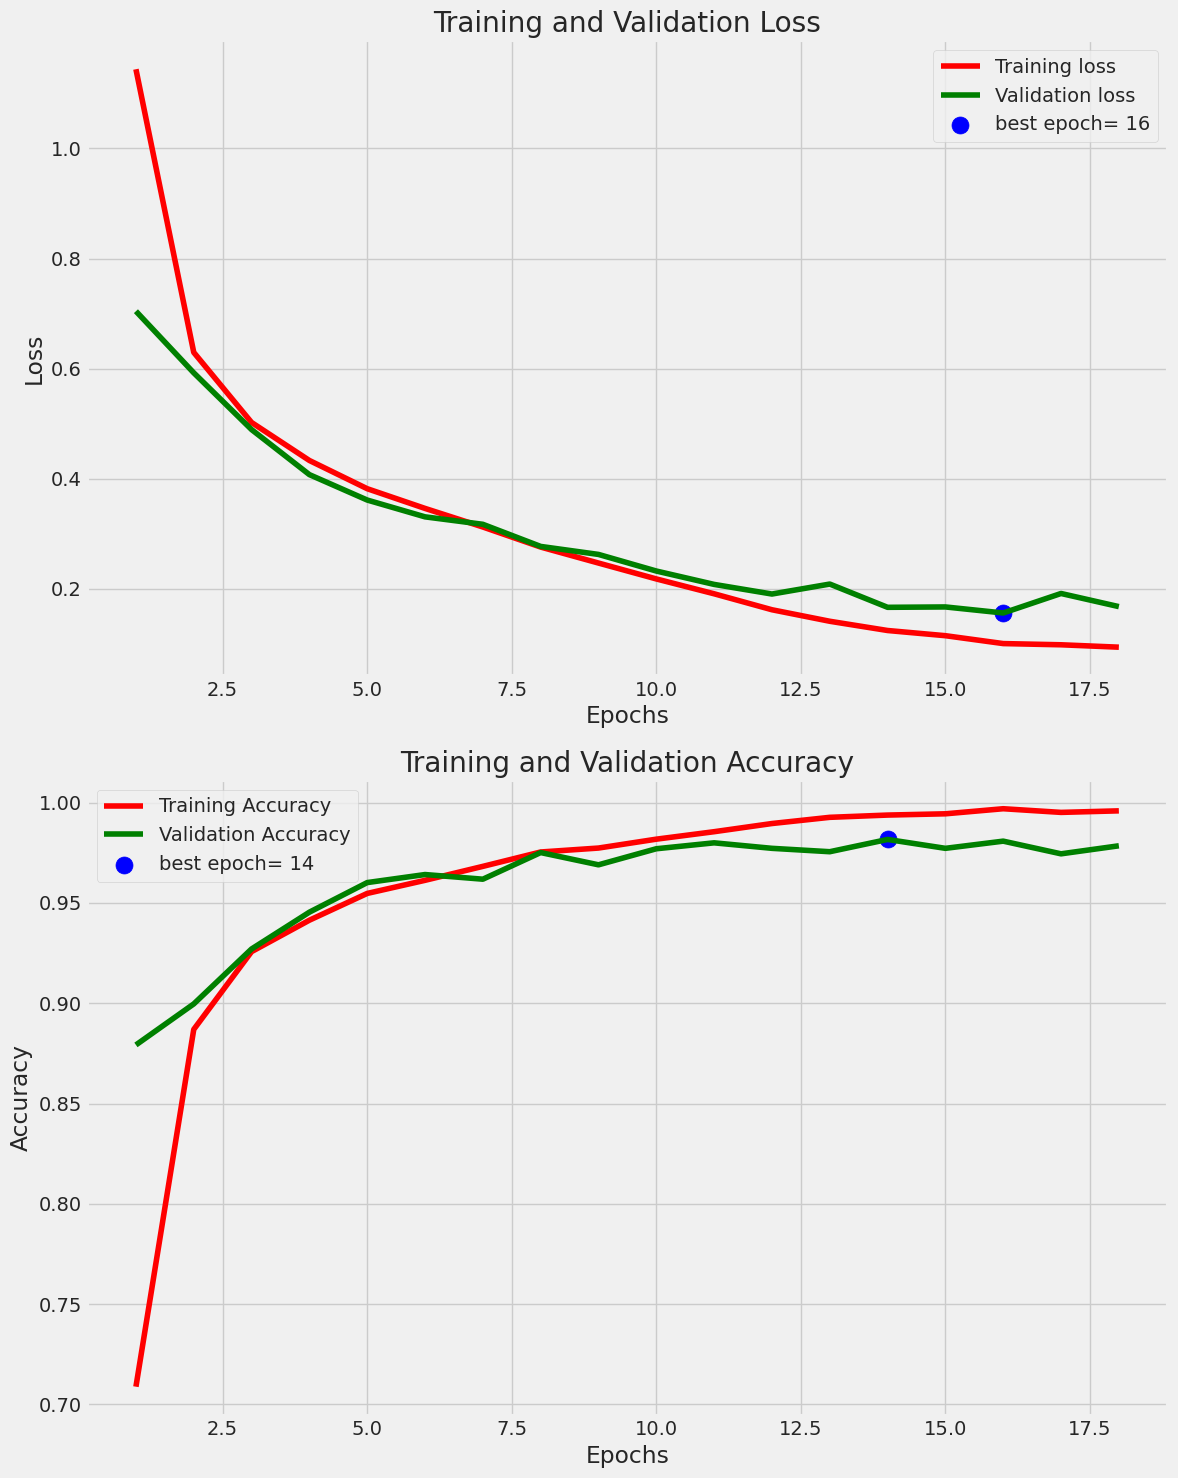

In [80]:
# Plot Loss-Acc Graphs:

plot_training_history(history)

149/149 [==============================] - 4s 28ms/step


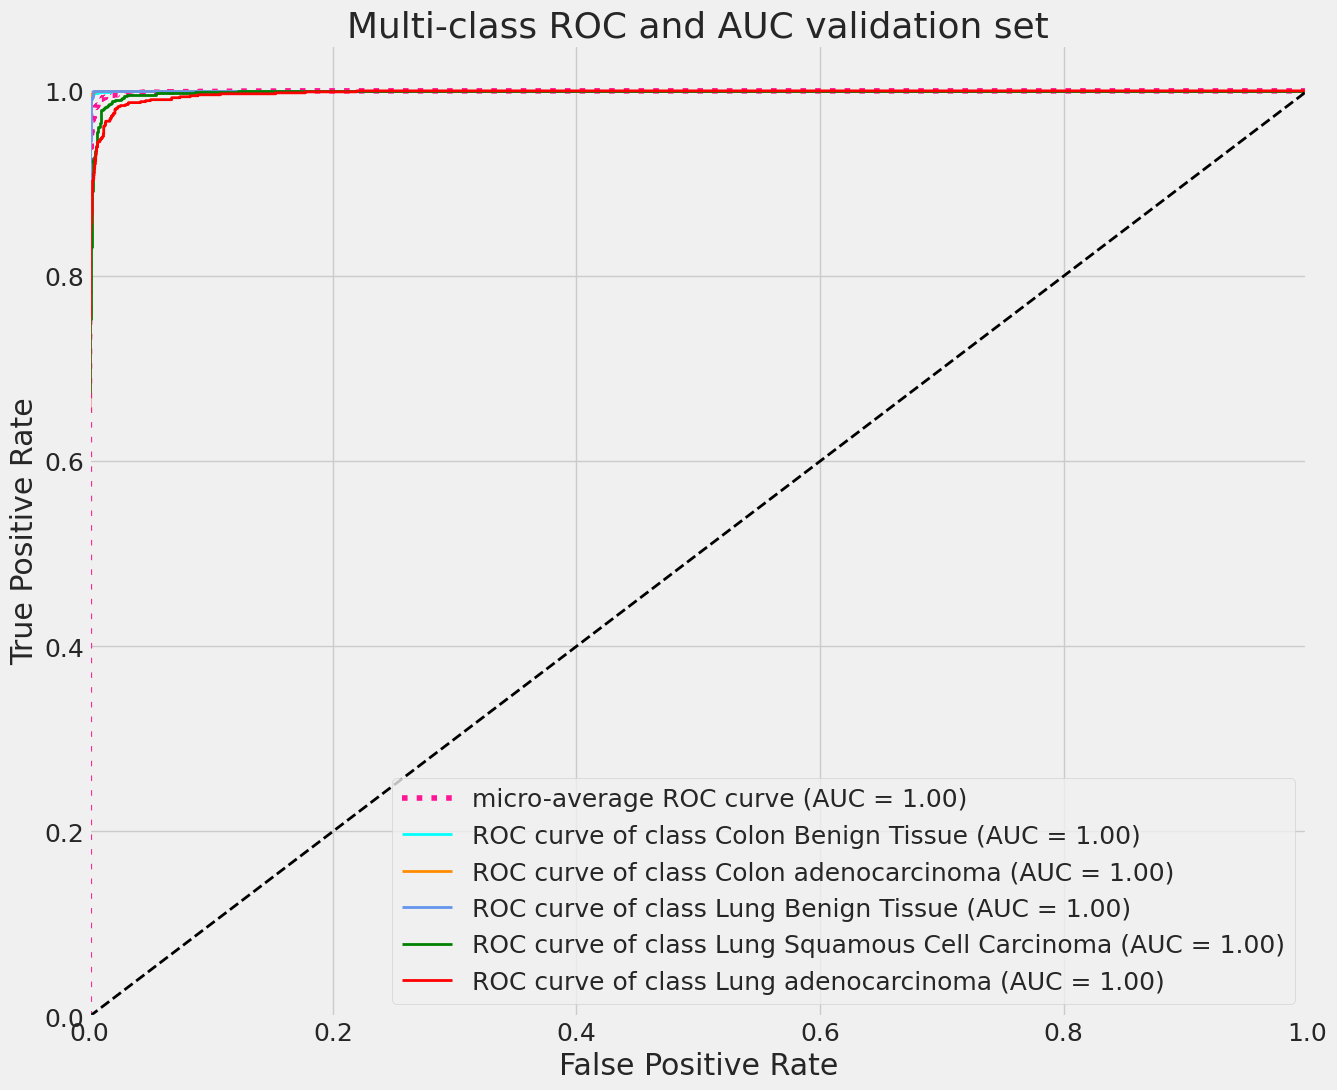

In [81]:
# Plotting ROC curvers :
unique_class_names = np.unique(labels)
## Get model predictions
y_val_pred_proba = model.predict(x_val)
y_test_pred_proba = model.predict(x_test)

## Convert predictions and true labels to class labels
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

## Plot ROC and calculate AUC for validation set
plot_multiclass_roc_auc(y_val_true, y_val_pred_proba, unique_class_names  , title = 'Multi-class ROC and AUC validation set')



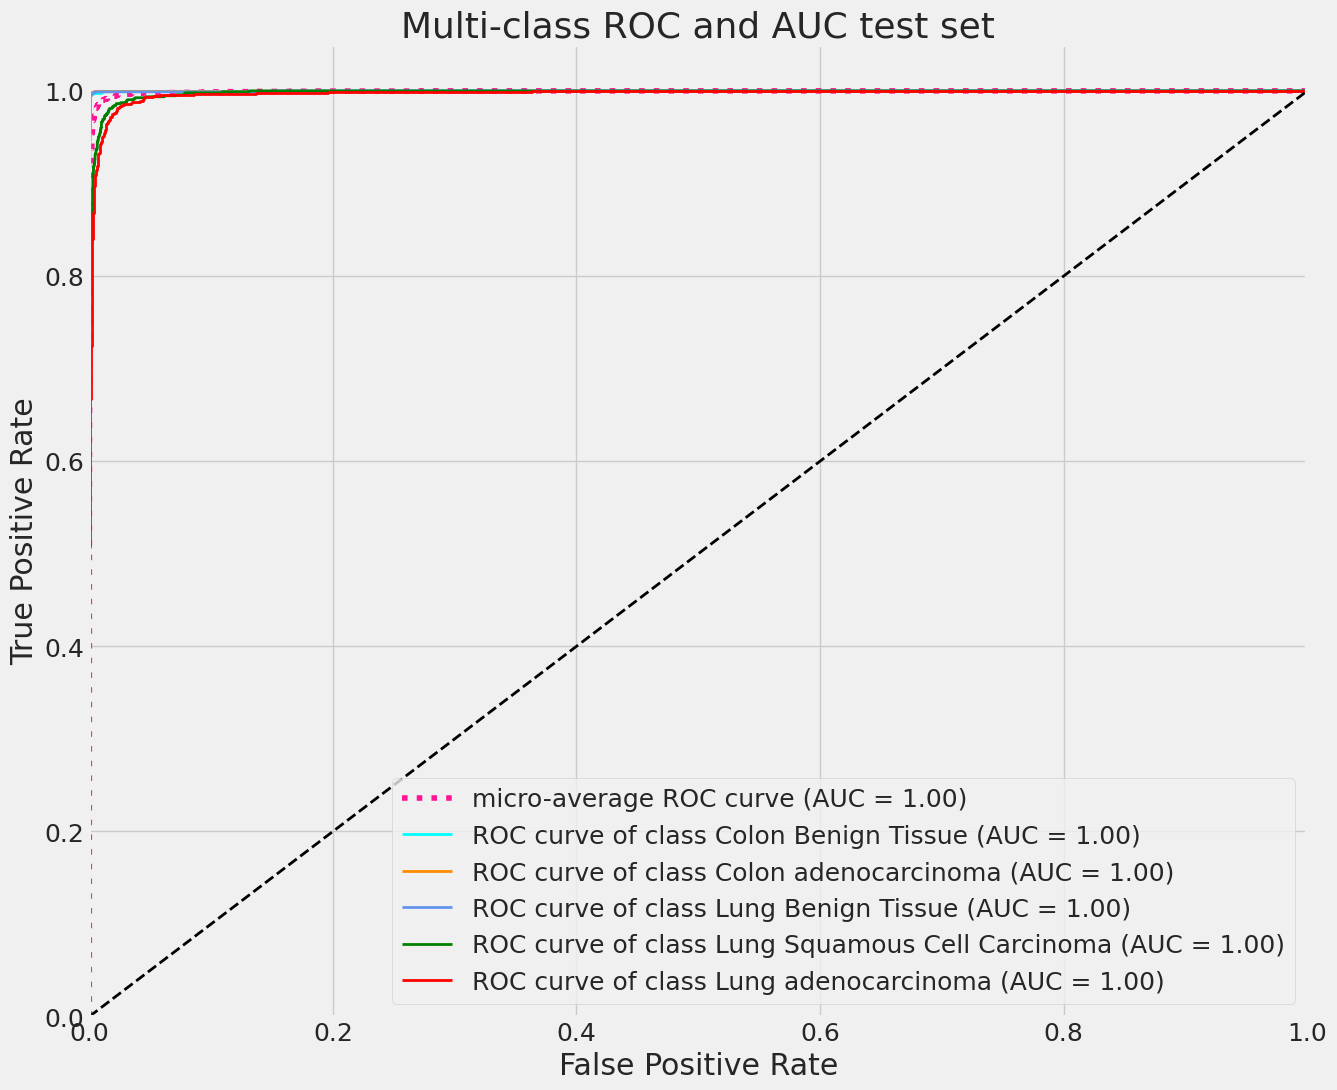

In [82]:
## Plot ROC and calculate AUC for test set
plot_multiclass_roc_auc(y_test_true, y_test_pred_proba,unique_class_names  , title = 'Multi-class ROC and AUC test set')

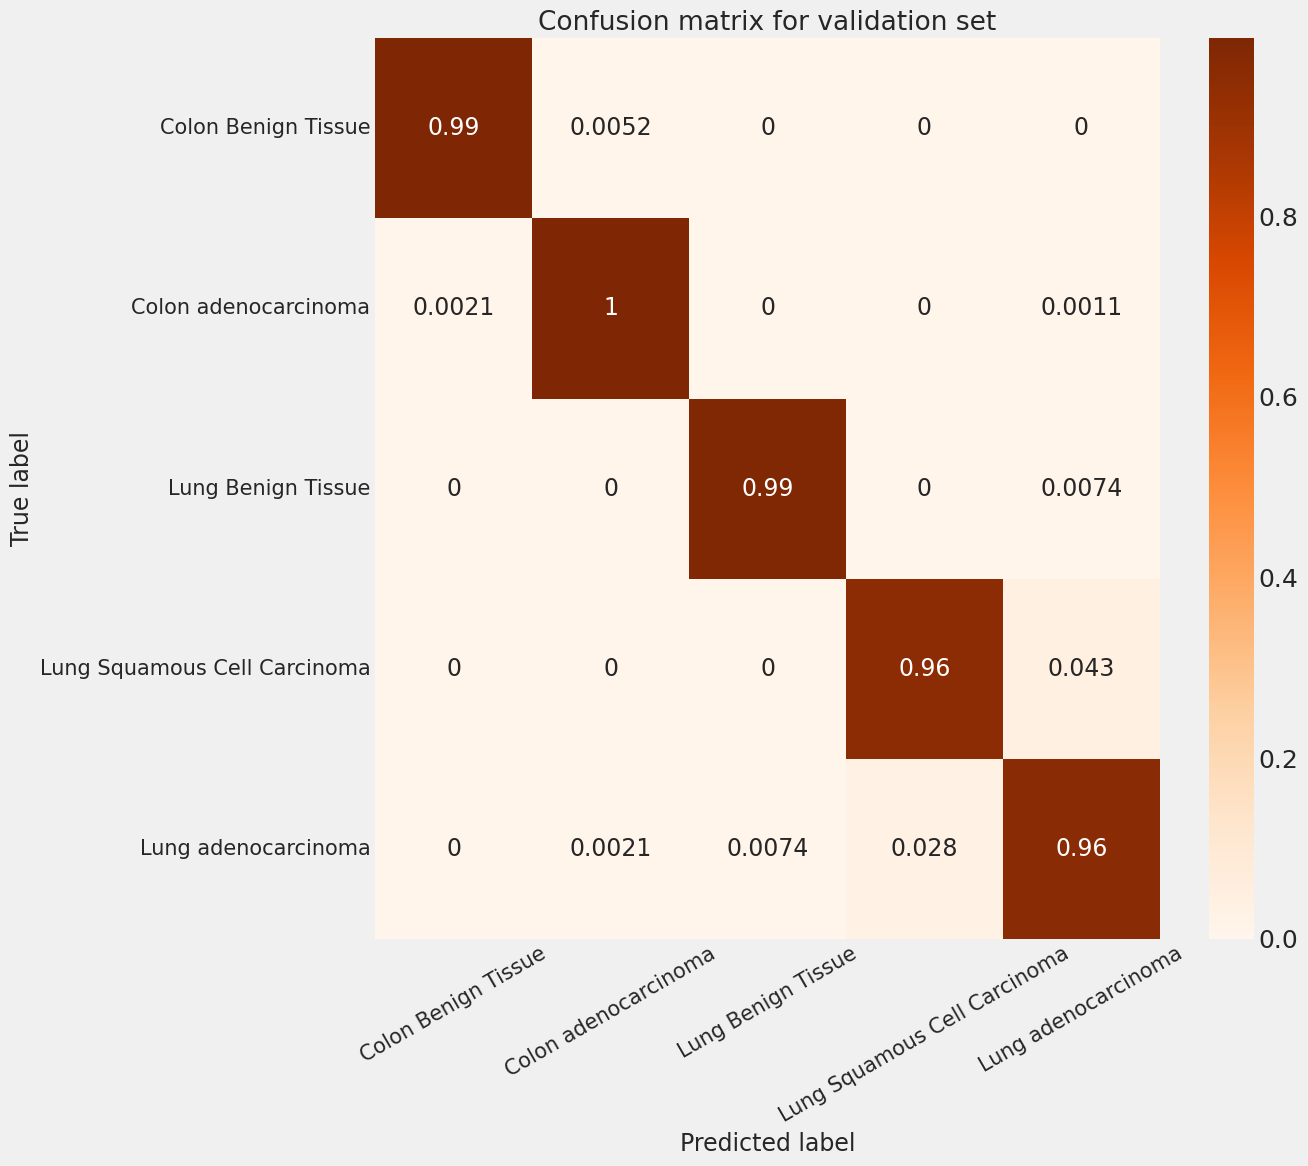

In [83]:
# Conf Matrix and classification Report:


## Extract unique class names from the `labels` array
unique_class_names = np.unique(labels)

## Map the class indices back to class names
y_val_true_names = indices_to_names(y_val_true, unique_class_names)
y_test_true_names = indices_to_names(y_test_true, unique_class_names)
y_val_pred_names = indices_to_names(y_val_pred, unique_class_names)
y_test_pred_names = indices_to_names(y_test_pred, unique_class_names)

## Plot confusion matrix for validation set with adjusted text size
plot_confusion_matrix(y_val_true_names, y_val_pred_names, classes=unique_class_names, title='Confusion matrix for validation set')



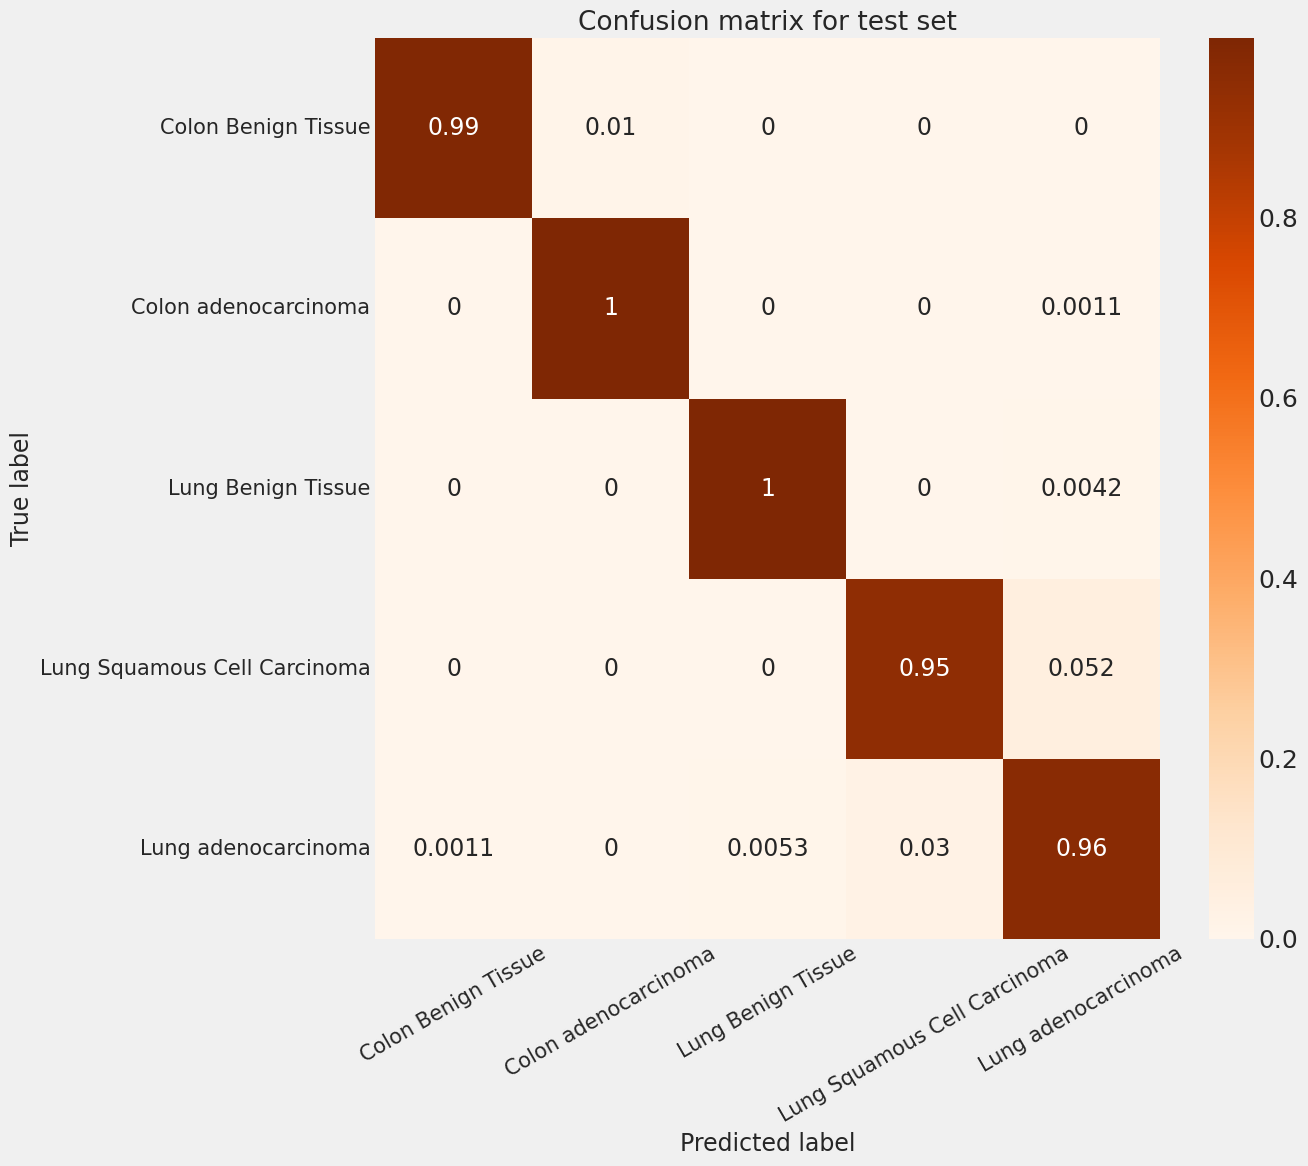

In [84]:
## Plot confusion matrix for test set with adjusted text size
plot_confusion_matrix(y_test_true_names, y_test_pred_names, classes=unique_class_names, title='Confusion matrix for test set')

In [85]:
## Calculate and print performance metrics for test set
print("\nTest Set Performance:")
print_performance_metrics(y_test_true, y_test_pred)

print(devider) 

## Calculate and print performance metrics for validation set
print("Validation Set Performance:")
print_performance_metrics(y_val_true, y_val_pred)


Test Set Performance:
Accuracy: 0.9793423
Precision: 0.9794086
Recall: 0.9792928
F1-Score: 0.9792967
-------------------------------------------------------------------------------------------------------------------------------------
Validation Set Performance:
Accuracy: 0.9808179
Precision: 0.9808278
Recall: 0.9807610
F1-Score: 0.9807703


# Evaluation of the transfer learning model:



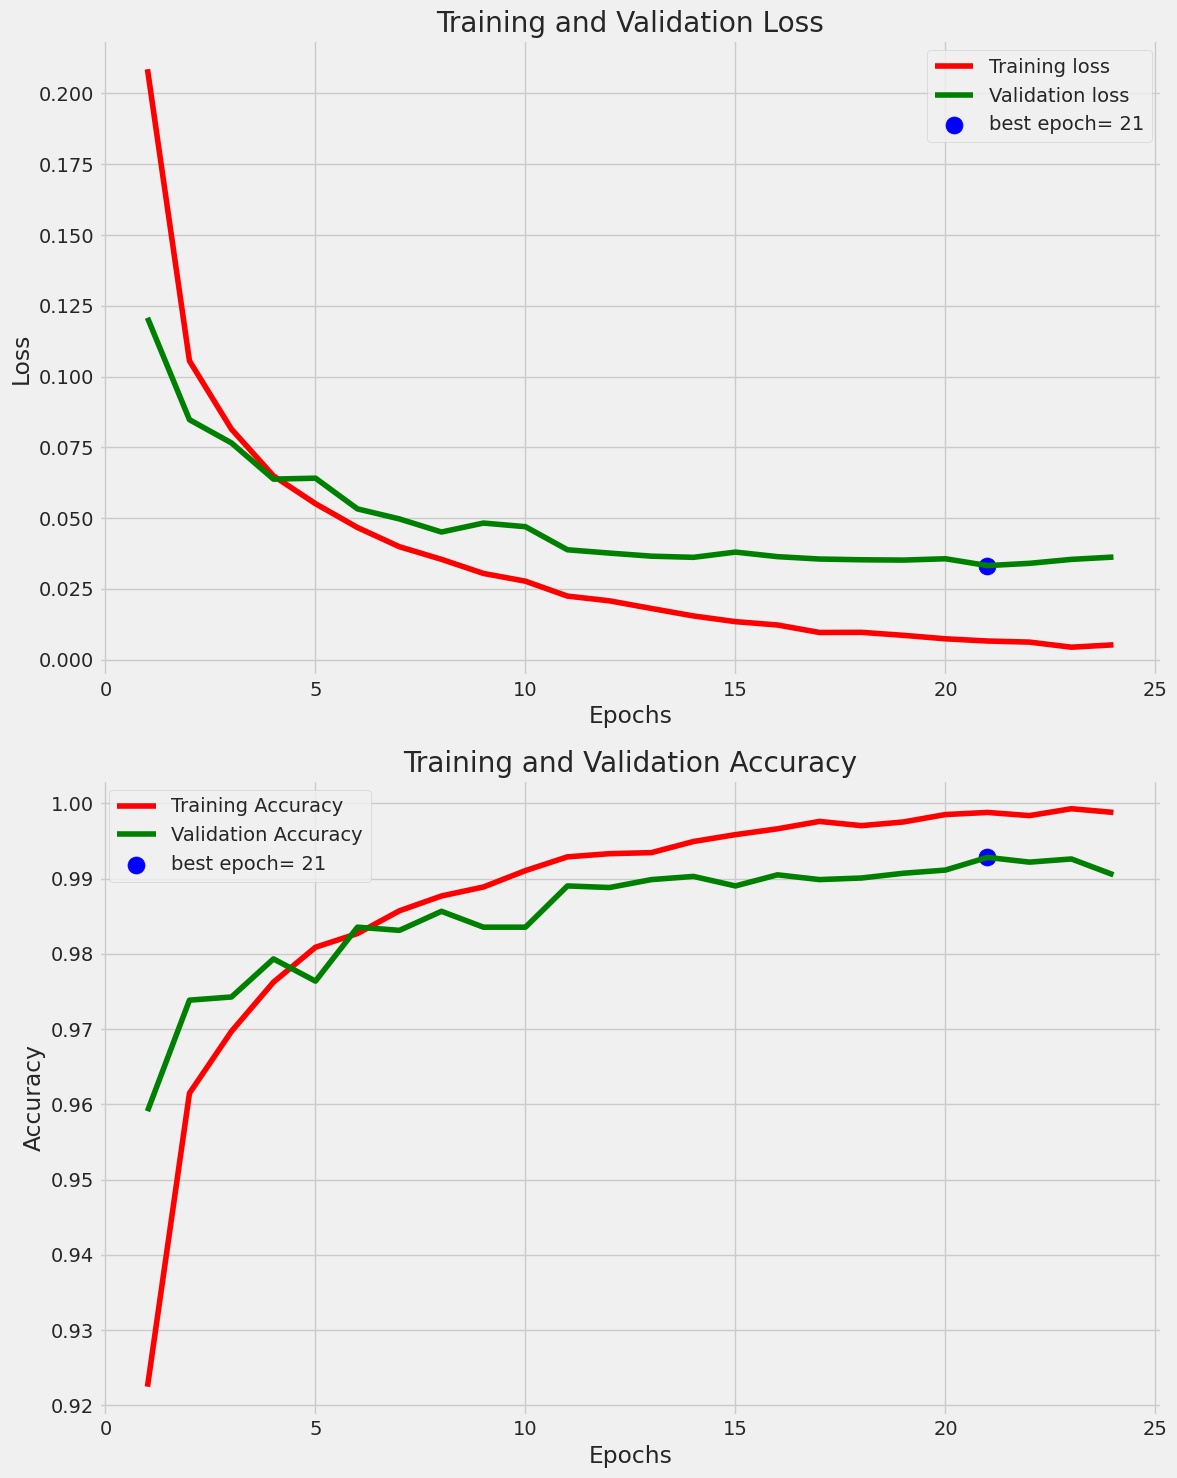

In [43]:
# Plot Loss-Acc Graphs:

plot_training_history(history)

149/149 [==============================] - 4s 24ms/step


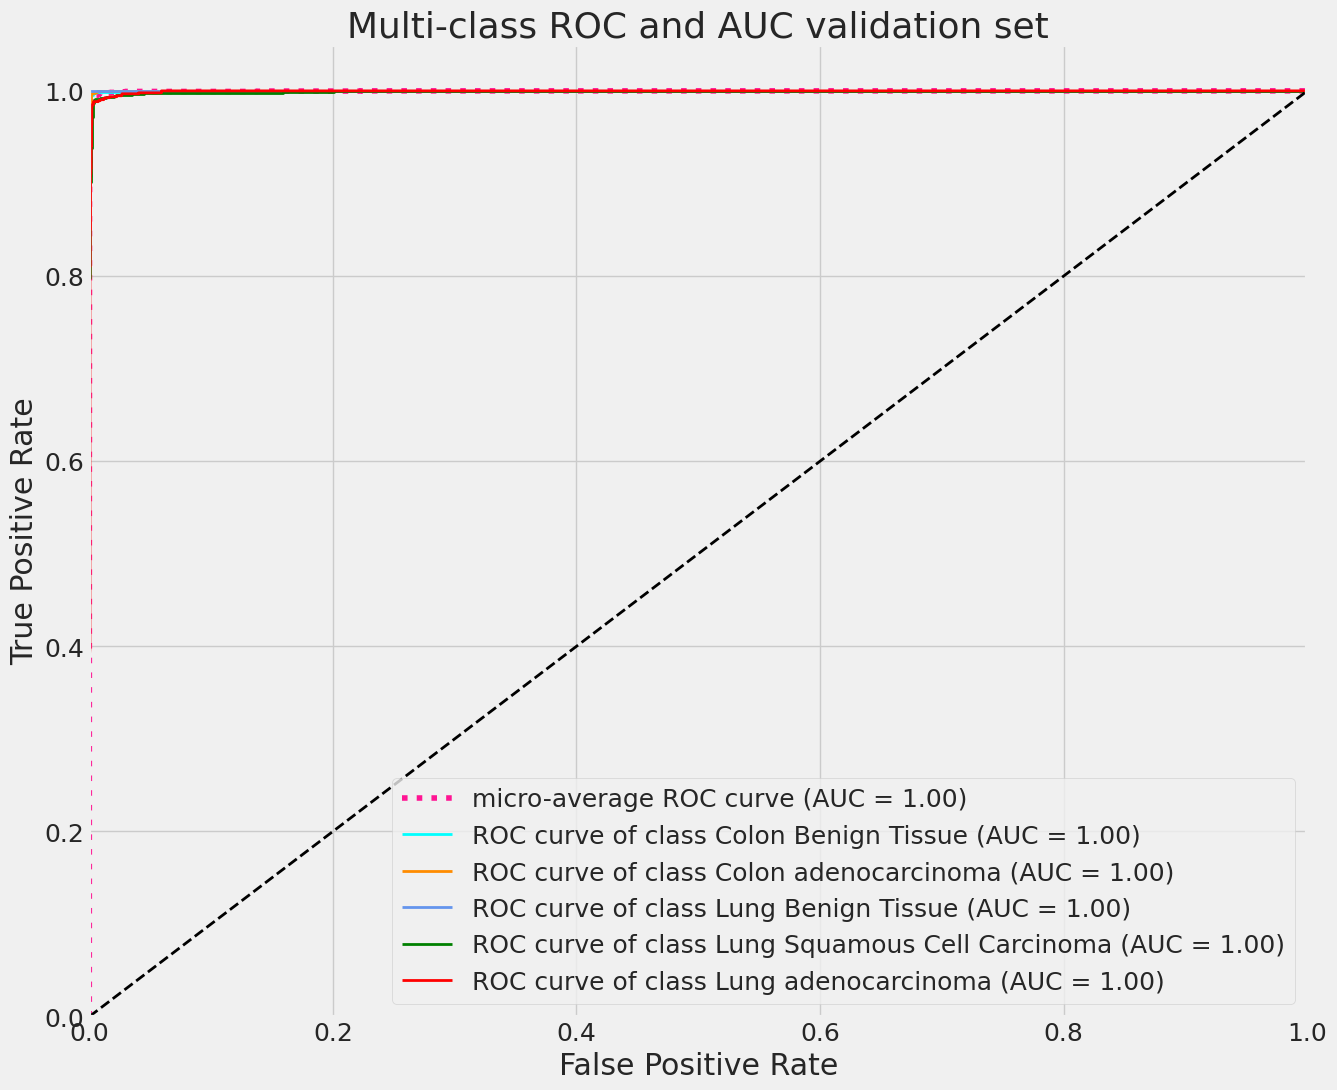

In [44]:
# Plotting ROC curvers :
unique_class_names = np.unique(labels)
## Get model predictions
y_val_pred_proba = model.predict(x_val)
y_test_pred_proba = model.predict(x_test)

## Convert predictions and true labels to class labels
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_val_true = np.argmax(y_val, axis=1)
y_test_true = np.argmax(y_test, axis=1)

## Plot ROC and calculate AUC for validation set
plot_multiclass_roc_auc(y_val_true, y_val_pred_proba, unique_class_names , title = 'Multi-class ROC and AUC validation set')

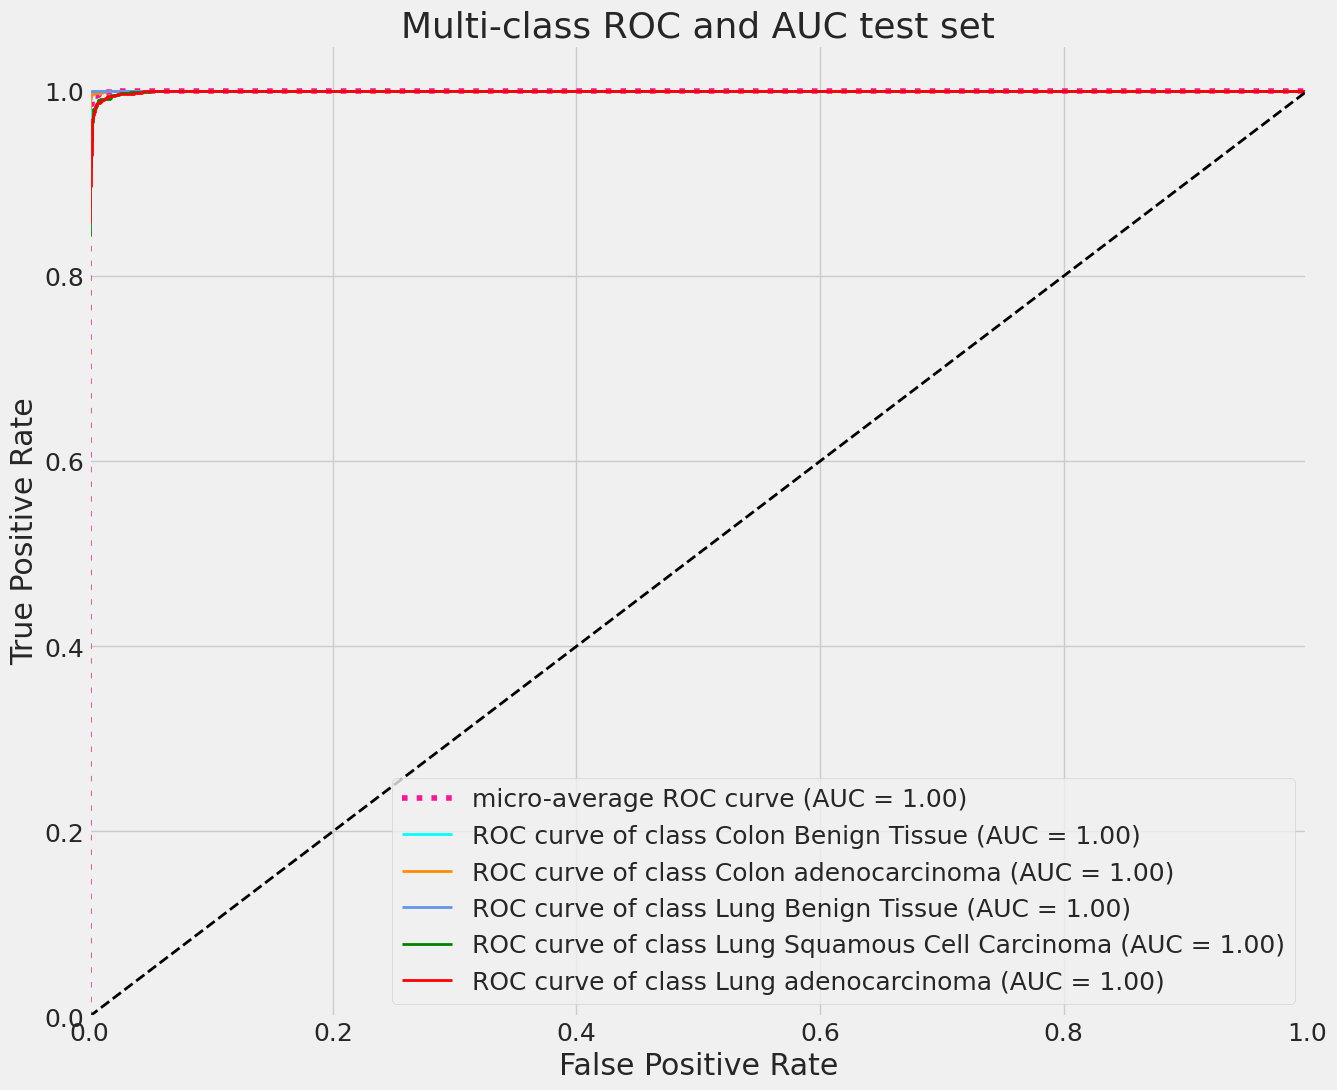

In [45]:
## Plot ROC and calculate AUC for test set
plot_multiclass_roc_auc(y_test_true, y_test_pred_proba,  unique_class_names,  title = 'Multi-class ROC and AUC test set')

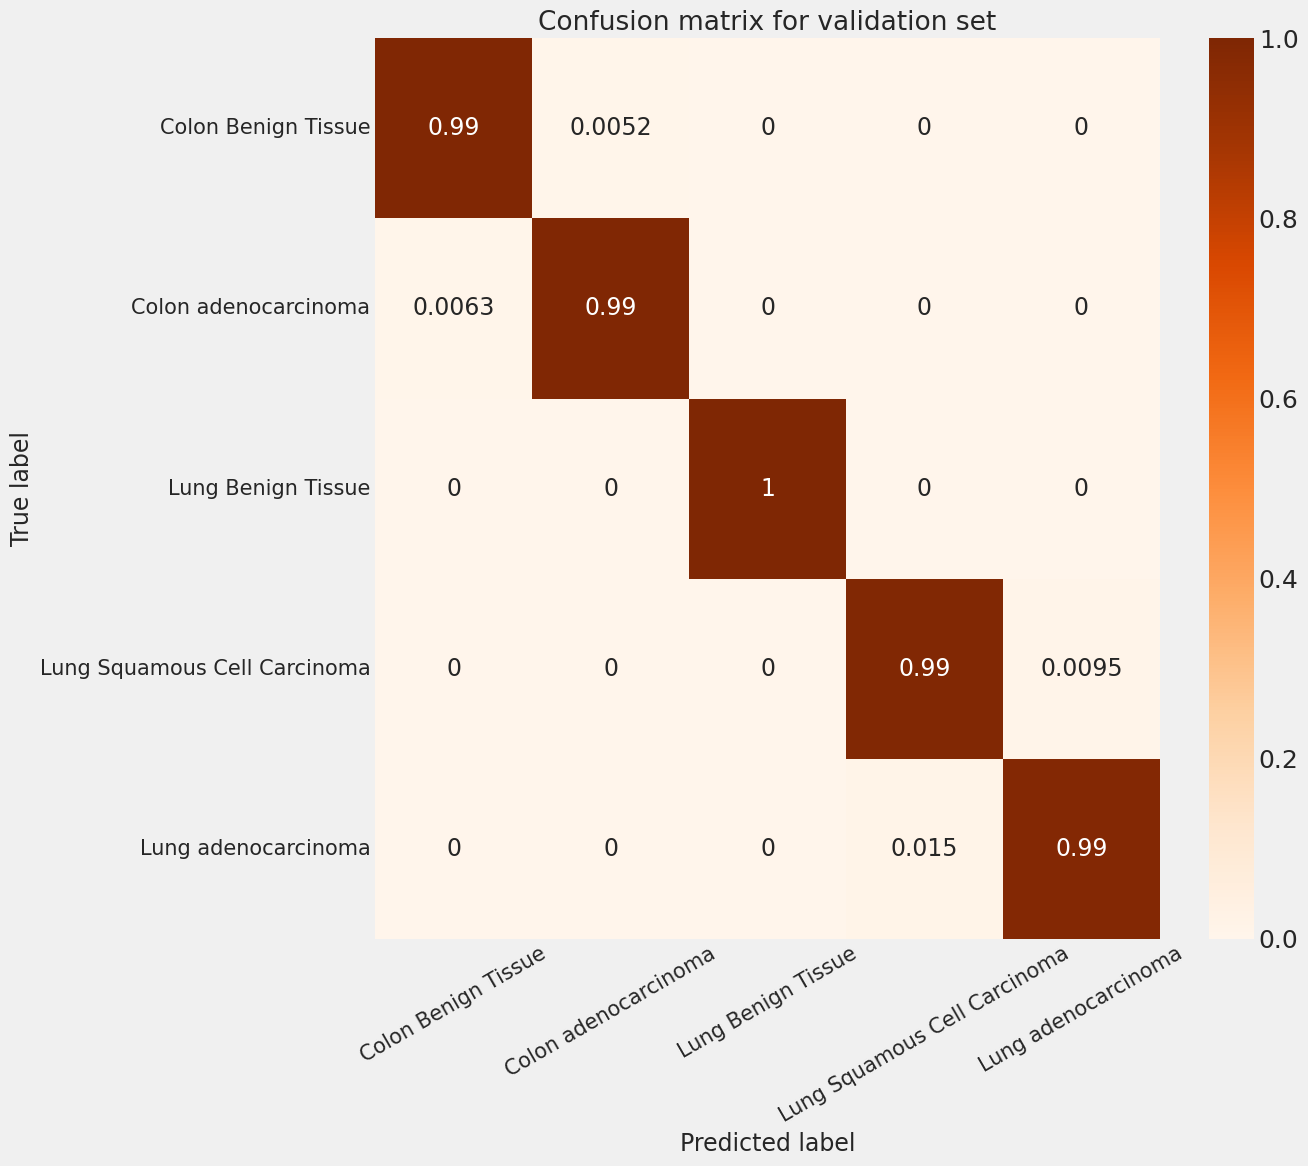

In [46]:
# Conf Matrix and classification Report:
## Extract unique class names from the `labels` array
unique_class_names = np.unique(labels)

## Map the class indices back to class names
y_val_true_names = indices_to_names(y_val_true, unique_class_names)
y_test_true_names = indices_to_names(y_test_true, unique_class_names)
y_val_pred_names = indices_to_names(y_val_pred, unique_class_names)
y_test_pred_names = indices_to_names(y_test_pred, unique_class_names)


## Plot confusion matrix for validation set with adjusted text size
plot_confusion_matrix(y_val_true_names, y_val_pred_names, unique_class_names, title='Confusion matrix for validation set')



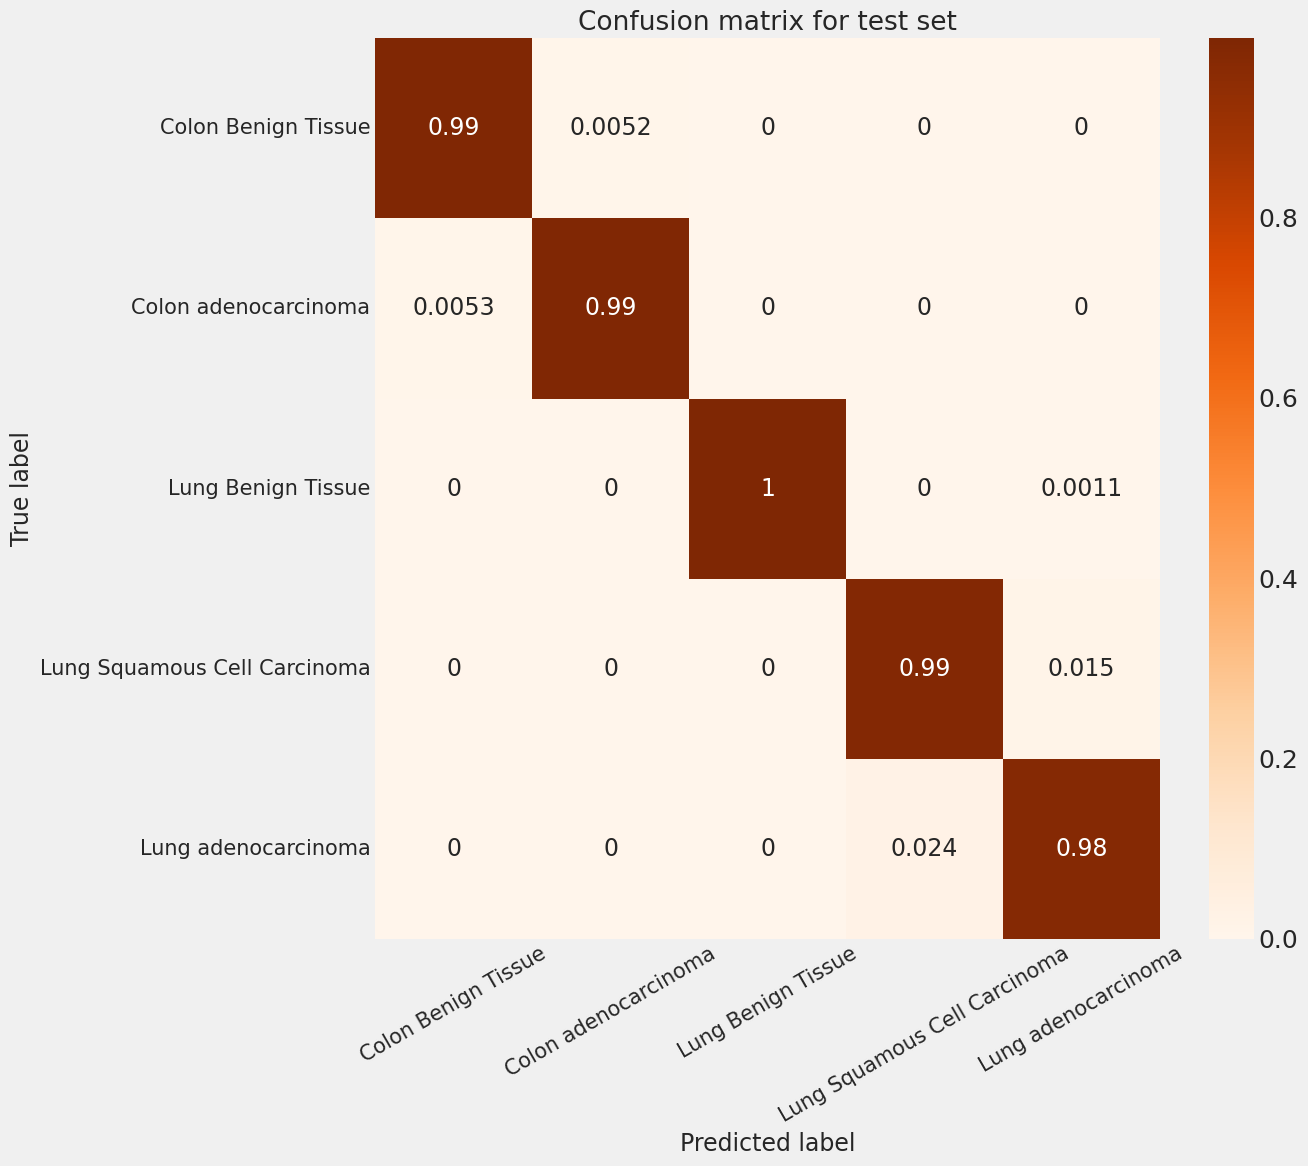

In [47]:
## Plot confusion matrix for test set with adjusted text size
plot_confusion_matrix(y_test_true_names, y_test_pred_names, classes=unique_class_names, title='Confusion matrix for test set')

In [48]:
## Calculate and print performance metrics for test set
print("\nTest Set Performance:")
print_performance_metrics(y_test_true, y_test_pred)

print(devider) 

## Calculate and print performance metrics for validation set
print("Validation Set Performance:")
print_performance_metrics(y_val_true, y_val_pred)


Test Set Performance:
Accuracy: 0.9898820
Precision: 0.9898802
Recall: 0.9898637
F1-Score: 0.9898639
-------------------------------------------------------------------------------------------------------------------------------------
Validation Set Performance:
Accuracy: 0.9928331
Precision: 0.9928286
Recall: 0.9928222
F1-Score: 0.9928225


# Extra Information : 

This segment of code addresses an issue identified within the dataset, specifically the presence of approximately 1280 duplicate images. Initially, this anomaly was overlooked; however, it became evident that these duplicates significantly influenced the results. The absence of explicit directives regarding the handling of duplicates in our guidelines necessitated a mention of this concern. Consequently, this oversight if not addressed led to data leakage, as both the training set (X_train) and the test set (X_test) ended up containing shared observations. The following sections showcase the logic used to adress this problem and also where it happens in the data pre and after the split. Such discrepancies are fixed and thus don't impact the models above.

Duplicate found: Original Index: 88 (Class: Colon adenocarcinoma), Duplicate Index: 156 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 100 (Class: Colon adenocarcinoma), Duplicate Index: 366 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 183 (Class: Colon adenocarcinoma), Duplicate Index: 443 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 254 (Class: Colon adenocarcinoma), Duplicate Index: 507 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 68 (Class: Colon adenocarcinoma), Duplicate Index: 516 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 574 (Class: Colon adenocarcinoma), Duplicate Index: 575 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 126 (Class: Colon adenocarcinoma), Duplicate Index: 578 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 137 (Class: Colon adenocarcinoma), Duplicate Index: 669 (Class: Colon adenocarcinoma)
Duplicate found: Original Index: 392 (Class: Colon

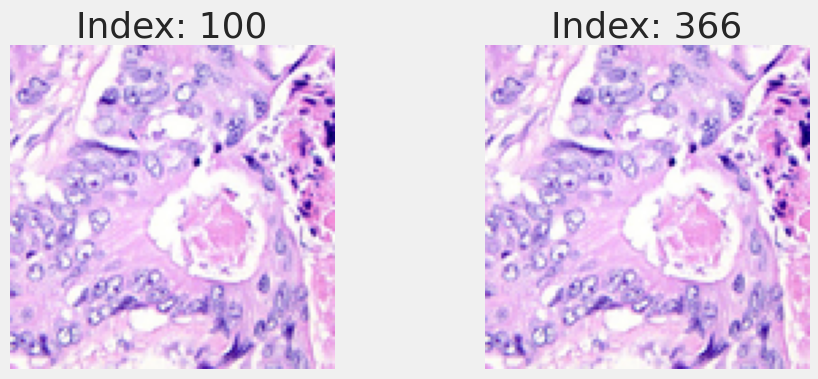

In [64]:

import hashlib
import numpy as np
import matplotlib.pyplot as plt


def hash_image(image_array):
    """Compute a hash of an image array."""
    return hashlib.sha256(image_array).hexdigest()

# Assuming 'data' is your dataset and 'labels' is an array of corresponding class labels
hashes = {}
duplicates = []
class_counts = {}

# Iterate through each image in the dataset and compute its hash
for idx, (image, label) in enumerate(zip(data, labels)):
    image_hash = hash_image(image.tobytes())
    if image_hash in hashes:
        # If the hash already exists, we've found a duplicate
        original_idx = hashes[image_hash]
        original_label = labels[original_idx]
        print(f"Duplicate found: Original Index: {original_idx} (Class: {original_label}), Duplicate Index: {idx} (Class: {label})")
        duplicates.append((original_idx, idx))
        
        # Count duplicates per class
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    else:
        # Otherwise, store the hash and index
        hashes[image_hash] = idx

# Print the total number of duplicates and their class distribution
total_duplicates = len(duplicates)
print(f"Total number of duplicates: {total_duplicates}")
print("Number of duplicates per class:")
for label, count in class_counts.items():
    print(f"Class {label}: {count}")

if duplicates:
    # Select a pair of duplicate indices to visualize
    idx1, idx2 = duplicates[1]  # Example: First pair of duplicates

    # Plot the two images side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(data[idx1], cmap='gray' if data[idx1].ndim == 2 else None)
    plt.title(f'Index: {idx1}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(data[idx2], cmap='gray' if data[idx2].ndim == 2 else None)
    plt.title(f'Index: {idx2}')
    plt.axis('off')

    plt.show()


Duplicate found between validation index: 73 and test index: 3231
Duplicate found between validation index: 99 and test index: 1019
Duplicate found between validation index: 133 and test index: 614
Duplicate found between validation index: 148 and test index: 109
Duplicate found between validation index: 150 and test index: 2438
Duplicate found between validation index: 156 and test index: 4966
Duplicate found between validation index: 163 and test index: 4575
Duplicate found between validation index: 188 and test index: 3835
Duplicate found between validation index: 195 and test index: 1582
Duplicate found between validation index: 216 and test index: 2568
Duplicate found between validation index: 232 and test index: 1074
Duplicate found between validation index: 334 and test index: 4827
Duplicate found between validation index: 357 and test index: 3559
Duplicate found between validation index: 369 and test index: 4058
Duplicate found between validation index: 431 and test index: 3299

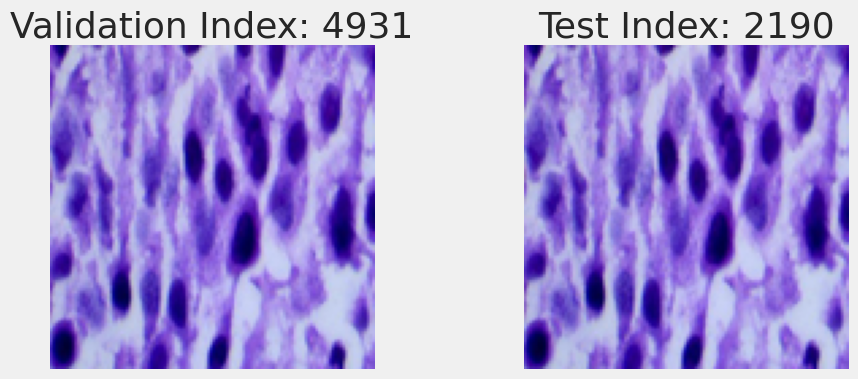

In [61]:
def hash_image(image_array):
    """Compute a hash of an image array."""
    return hashlib.sha256(image_array).hexdigest()

def find_and_plot_duplicates(x_val, x_test):
    val_hashes = {idx: hash_image(image.tobytes()) for idx, image in enumerate(x_val)}
    test_hashes = {idx: hash_image(image.tobytes()) for idx, image in enumerate(x_test)}

    duplicates = []
    for val_idx, val_hash in val_hashes.items():
        for test_idx, test_hash in test_hashes.items():
            if val_hash == test_hash:
                print(f"Duplicate found between validation index: {val_idx} and test index: {test_idx}")
                duplicates.append((val_idx, test_idx))
                break  # Stop after finding the first duplicate for this val image

    print(len(duplicates))

    # Examples of duplicate indices
    if duplicates:
        print("Examples of duplicate indices:", duplicates[:5])  # Print first 5 pairs of duplicate indices as examples
        # Visualize the first pair of duplicates
        idx1, idx2 = duplicates[111]  # Get the first pair
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(x_val[idx1], cmap='gray' if x_val[idx1].ndim == 2 else None)
        plt.title(f'Validation Index: {idx1}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(x_test[idx2], cmap='gray' if x_test[idx2].ndim == 2 else None)
        plt.title(f'Test Index: {idx2}')
        plt.axis('off')
        
        plt.show()
    else:
        print("No duplicates found between validation and test sets.")

# Example usage
find_and_plot_duplicates(x_val, x_test)
